In [1]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
import json

**DATASET UNDERSTANDING**

In [2]:
json_file_path = '/kaggle/input/input-275/train_data.json'
with open(json_file_path, "r", encoding="utf-8") as f:
    cv_data = json.load(f)

In [3]:
if isinstance(cv_data, list):
    docs = cv_data
elif isinstance(cv_data, dict):
    docs = [cv_data]
else:
    raise ValueError("Unsupported JSON file format.")
num_docs = len(docs)
print(f"Total documents: {num_docs}")

Total documents: 200


In [4]:
cv_data[0]

['Govardhana K Senior Software Engineer  Bengaluru, Karnataka, Karnataka - Email me on Indeed: indeed.com/r/Govardhana-K/ b2de315d95905b68  Total IT experience 5 Years 6 Months Cloud Lending Solutions INC 4 Month • Salesforce Developer Oracle 5 Years 2 Month • Core Java Developer Languages Core Java, Go Lang Oracle PL-SQL programming, Sales Force Developer with APEX.  Designations & Promotions  Willing to relocate: Anywhere  WORK EXPERIENCE  Senior Software Engineer  Cloud Lending Solutions -  Bangalore, Karnataka -  January 2018 to Present  Present  Senior Consultant  Oracle -  Bangalore, Karnataka -  November 2016 to December 2017  Staff Consultant  Oracle -  Bangalore, Karnataka -  January 2014 to October 2016  Associate Consultant  Oracle -  Bangalore, Karnataka -  November 2012 to December 2013  EDUCATION  B.E in Computer Science Engineering  Adithya Institute of Technology -  Tamil Nadu  September 2008 to June 2012  https://www.indeed.com/r/Govardhana-K/b2de315d95905b68?isid=rex-

In [5]:
documents = cv_data  

# Initialize lists to accumulate stats
text_lengths = []        
annotations_count = []    
annotation_labels = []  

for doc in documents:
    if not isinstance(doc, list) or len(doc) != 2:
        print(f"Skipping document with unexpected structure: {doc}")
        continue
    
    text = doc[0]
    ann_dict = doc[1]
    
    text_lengths.append(len(text))
    entities = ann_dict.get("entities", [])
    annotations_count.append(len(entities))
    
    for entity in entities:
        if len(entity) >= 3:
            annotation_labels.append(entity[2])
        else:
            print(f"Unexpected entity format: {entity}")

# Calculate additional statistics
num_docs = len(text_lengths)
total_annotations = sum(annotations_count)
avg_text_length = sum(text_lengths) / num_docs if num_docs > 0 else 0
avg_annotations = total_annotations / num_docs if num_docs > 0 else 0

print("========== Basic Dataset Statistics ==========")
print(f"Total documents: {num_docs}")
print(f"Total annotations: {total_annotations}")
print(f"Average text length: {avg_text_length:.2f} characters")
print(f"Average annotations per document: {avg_annotations:.2f}")

========== Basic Dataset Statistics ==========
Total documents: 200
Total annotations: 3206
Average text length: 3704.95 characters
Average annotations per document: 16.03


In [6]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
label_counter = Counter(annotation_labels)
print("\n---------- Distinct Annotation Labels ----------")
for label, count in label_counter.items():
    print(f"{label}: {count}")


---------- Distinct Annotation Labels ----------
Companies worked at: 676
Skills: 417
Graduation Year: 222
College Name: 291
Degree: 268
Designation: 473
Email Address: 229
Location: 381
Name: 205
Years of Experience: 42
UNKNOWN: 2


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


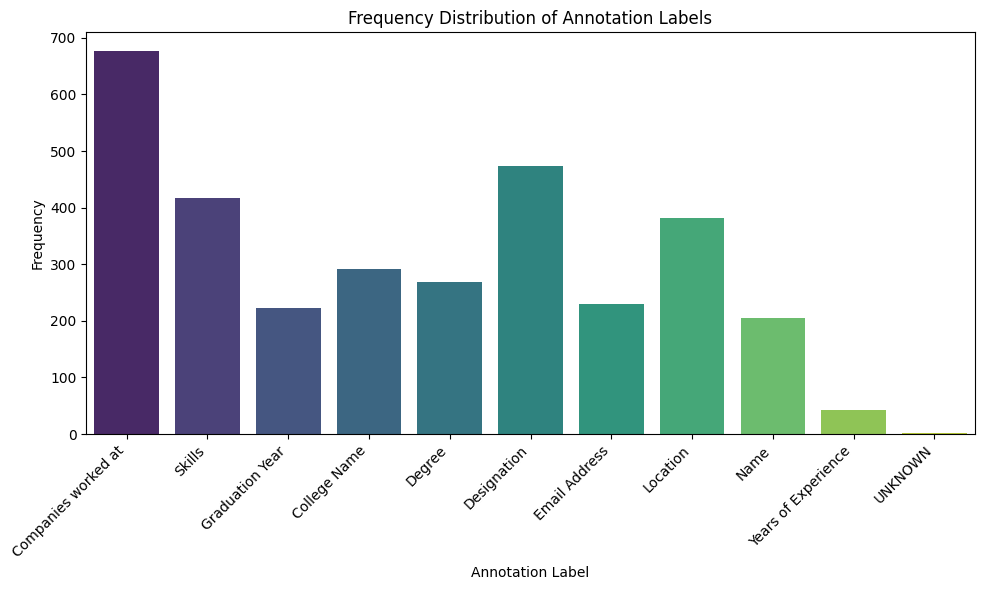

In [8]:
plt.figure(figsize=(10,6))
sns.barplot(x=list(label_counter.keys()), y=list(label_counter.values()), palette="viridis")
plt.xlabel("Annotation Label")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Annotation Labels")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


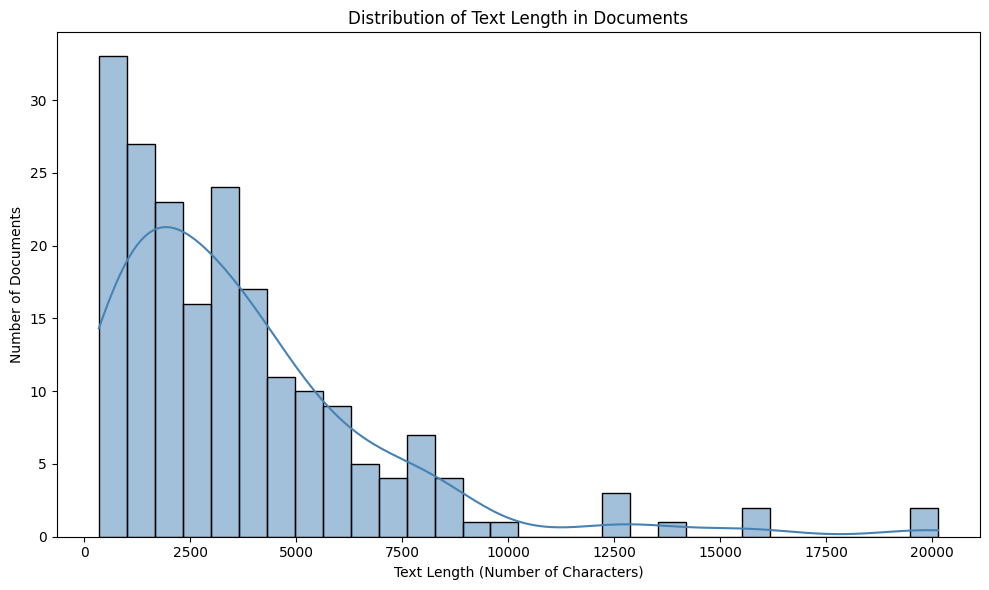

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(text_lengths, bins=30, kde=True, color="steelblue")
plt.xlabel("Text Length (Number of Characters)")
plt.ylabel("Number of Documents")
plt.title("Distribution of Text Length in Documents")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


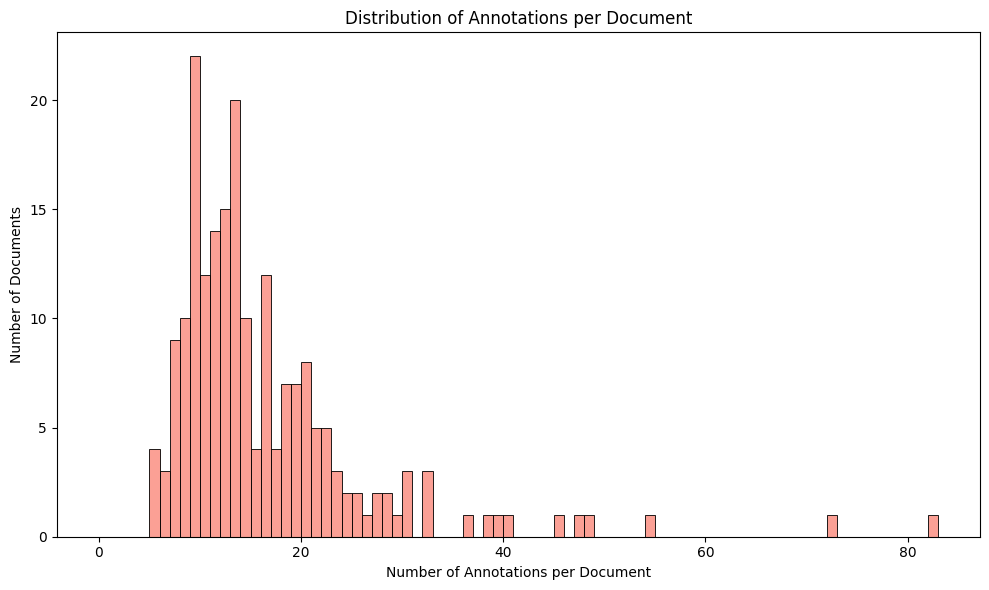

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(annotations_count, bins=range(0, max(annotations_count)+2), color='salmon', edgecolor='black')
plt.xlabel("Number of Annotations per Document")
plt.ylabel("Number of Documents")
plt.title("Distribution of Annotations per Document")
plt.tight_layout()
plt.show()

**TRAIN MODEL**

In [11]:
def get_spacy_doc(error_log_file, data):
    nlp = spacy.load("en_core_web_sm")
    db = DocBin()

    for item in tqdm(data, desc="Processing documents"):
        try:
            text, annotation_dict = item
            
            # Ensure text is properly encoded/decoded.
            text = text.encode("utf-8", errors="replace").decode("utf-8")
            doc = nlp.make_doc(text)
            ents = []
            entity_indices = set()
            
            annotations = annotation_dict.get("entities", [])
            for annotation in annotations:
                if len(annotation) < 3:
                    error_log_file.write(f"Skipping malformed annotation: {annotation}\n")
                    continue

                start, end, label = annotation
                label = label.upper()
                
                # Skip this entity if any index in the span is already used.
                if any(idx in entity_indices for idx in range(start, end)):
                    continue
                entity_indices.update(range(start, end))

                span = doc.char_span(start, end, label=label, alignment_mode="strict")
                if span is None:
                    error_log_file.write(
                        f"Skipping entity: {label} [{start}-{end}] in text:\n{text[:100]}...\n"
                    )
                    continue
                ents.append(span)
            doc.ents = ents
            db.add(doc)
        except Exception as e:
            error_log_file.write(f"Error processing document starting with '{text[:50]}...': {e}\n")
            continue

    return db

In [12]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(cv_data, test_size=0.3)

In [13]:
len(train), len(test)

(140, 60)

In [14]:
file = open("error_data.txt", "w")
db = get_spacy_doc(file, cv_data)
db.to_disk("train_data.spacy")

db = get_spacy_doc(file, test)
db.to_disk("test_data.spacy")

file.close()

Processing documents: 100%|██████████| 60/60 [00:00<00:00, 109.07it/s]


In [15]:
!pip install spacy-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.8/758.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 100.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninst

In [16]:
!python -m spacy init fill-config /kaggle/input/input-275/base_config.cfg config.cfg

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [17]:
!python -m spacy train /kaggle/working/config.cfg \
--output /kaggle/working/output \
--paths.train /kaggle/working/train_data.spacy \
--paths.dev /kaggle/working/test_data.spacy \
--gpu-id 0

✔ Created output directory: /kaggle/working/output
ℹ Saving to output directory: /kaggle/working/output
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2025-05-27 16:23:54,232] [INFO] Set up nlp object from config
[2025-05-27 16:23:54,251] [INFO] Pipeline: ['transformer', 'ner']
[2025-05-27 16:23:54,254] [INFO] Created vocabulary
[2025-05-27 16:23:54,254] [INFO] Finished initializing nlp object
tokenizer_config.json: 100%|██████████████████| 25.0/25.0 [00:00<00:00, 168kB/s]
config.json: 100%|█████████████████████████████| 481/481 [00:00<00:00, 2.64MB/s]
vocab.json: 100%|████████████████████████████| 899k/899k [00:00<00:00, 2.07MB/s]
merges.txt: 100%|████████████████████████████| 456k/456k [00:00<00:00, 1.27MB/s]
tokenizer.json: 100%|██████████████████████| 1.36M/1.36M [00:00<00:00, 1.85MB/s]
2025-05-27 16:24:05.606236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register fa